In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances
import textwrap
from mypackage import dir

In [2]:
# Environment variables
project = 'belgium'
data = dir.make_dir(project) 
processed = data('processed')
outputs = data('outputs')

In [3]:
def stratified_sample(df):
    if df.name == 0:  # Si la categoría es 0, toma 30%
        return df.sample(frac=0.3, random_state=42)
    else:  # Para categorías 1 y 2, toma 10%
        return df.sample(frac=0.1, random_state=42) 

def agregar_saltos_linea(texto, ancho=50):
    """
    Versión usando el módulo textwrap de Python para un control más preciso.
    
    Parámetros:
    - texto: str - Texto original
    - ancho: int - Ancho máximo de caracteres por línea
    
    Retorna:
    - str - Texto con saltos de línea HTML
    """
    texto = ' '.join(str(texto).split())  # Normalizar espacios
    return '<br>'.join(textwrap.wrap(texto, width=ancho))

def filter_centroide(df):
    df1 = df.copy()
    df1 = df1[df1['label'] == 0]
    df1 = df1[df1['distancia_al_centroide']<0.70]

    df2 = df.copy()
    df2 = df2[df2['label'] == 2]
    df2 = df2[df2['distancia_al_centroide']<0.60]

    df = pd.concat([df1,df2], ignore_index=True)

    return df

def plot_embeddings(df: pd.DataFrame, title: str, save: bool = False):
    """
    Genera y muestra un grafico 100 palabras

    Args:
        df (pd.DataFrame): Dataframe limpio.
        titulo (str): Título para el gráfico.
        save: Whether to save the visualization to an HTML file
    """
    fig = px.scatter(df, x="x", y="y", 
                     size='importancia',
                     color="id_topic", 
                     symbol='label',
                     hover_data=['texto'],
                     labels=labels,
                     )

    # Customize text positioning (consider clarity and visual balance)
    fig.update_traces(textposition='top center')  # or 'top center' based on preference

    fig.update_layout(template = "plotly_dark")

    # Informative layout with custom title
    fig.update_layout(
        title_text=f'Cloud <br><sup> {title} </sup>',  # Title
        title_x=0.5,  # Centered title
        xaxis_title=' ',  # Add meaningful axis labels
        yaxis_title=' ',
        font=dict(family="Arial", size=12),  # Consistent font style and size
        # plot_bgcolor='white',  # Clean background color
        xaxis_tickformat='.2f',  # Format x-axis ticks for readability (adjust as needed)
        yaxis_tickformat='.2f',  # Format y-axis ticks for readability (adjust as needed)

        xaxis=dict(
            ticks='',
            showticklabels=False
        ),
        yaxis=dict(
            ticks='',
            showticklabels=False
        )

    )

    # Interactive elements (optional)
    fig.update_layout(hovermode='closest')  # Hover over a point for details
    fig.update_traces(opacity=0.8)  # Adjust marker opacity for better visibility

    # Advanced styling (optional)
    fig.update_xaxes(showline=False, linewidth=2, linecolor='gray')  # X-axis formatting
    fig.update_yaxes(showline=False, linewidth=2, linecolor='gray')  # Y-axis formatting

    if save:
        fig.write_html(outputs / f'{title}.html'.format('cloud'))

    
    # Display the enhanced plot
    fig.show()

labels={'words':'Word',
        'group':'Group',
        'id_topic':'Topic',
        'label': 'Label',
        'importancia':'Importancia',
        'texto':'Comentario original',
        'x':'Dim 1',
        'y':'Dim 2',
    }

In [4]:
## Cargar el dataset con los textos originales
df = pd.read_parquet(processed/'df_hotel_transformados.parquet.gzip')
df = df.loc[:,['id', 'texto', 'label', 'importancia_tfidf']]
df.head()

,id,texto,label,importancia_tfidf
0,1,el mejor lugar para comer sushi. excelente lug...,2,3.833645
1,2,vista hermosa!. me sorprendió la maravillosa v...,2,4.635010
2,3,"desastroso. buenas noches, ante todo explicar...",0,7.507874
3,4,todo bien excepto que se niegan a dar vasos de...,1,3.936999
4,5,el mejor zoologico de méxico. el ambiente es m...,2,3.567779


In [5]:
## Cargar los embeddings y hacer un muestreo
df_embeddings = pd.read_parquet(processed/'df_embeddings.parquet.gzip')
df_embeddings = pd.merge(df_embeddings, df, how='left', on=['id']) 
df_embeddings = df_embeddings.dropna(subset=['importancia_tfidf'])
# df_embeddings = df_embeddings.groupby('label').apply(lambda x: x.sample(frac=0.15)).reset_index(drop=True)
df_embeddings = df_embeddings.groupby('label', group_keys=False).apply(stratified_sample).reset_index(drop=True)
df_embeddings.head()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18548\1168096066.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_embeddings = df_embeddings.groupby('label', group_keys=False).apply(stratified_sample).reset_index(drop=True)


,id,embeddings,texto,label,importancia_tfidf
0,73061,"[0.003810586640611291, 0.02859099768102169, -0...",pura imagen! calidad deficiente.. es un restau...,0,4.576803
1,113854,"[0.01165767665952444, -0.04814380034804344, -0...",pésimo servicio. no tienen disposición ni tact...,0,4.906597
2,131548,"[0.0002807415439747274, 0.04143811762332916, -...",bajo restauration. siento decir que no pudimos...,0,3.189304
3,73584,"[-0.0033760960213840008, -0.055160701274871826...","no lo recomiendo. no recomiendo este hotel, el...",0,3.503693
4,5054,"[-0.0008811472216621041, -0.05881946161389351,...",pesimo servicio. muy lento el servicio y los m...,0,4.210060


In [6]:
df_topicos_automaticos = pd.read_parquet(processed/'df_topicos_automaticos.parquet.gzip')
df_topicos_automaticos = df_topicos_automaticos.loc[:,['id', 'topico_1', 'topico_2', 'topico_3']]
df_topicos_automaticos = pd.merge(df_embeddings, df_topicos_automaticos, how='left', on=['id']) 
df_topicos_automaticos = df_topicos_automaticos.dropna(subset=['topico_1'])
df_topicos_automaticos.head()

,id,embeddings,texto,label,importancia_tfidf,topico_1,topico_2,topico_3
0,73061,"[0.003810586640611291, 0.02859099768102169, -0...",pura imagen! calidad deficiente.. es un restau...,0,4.576803,2.0,4.0,0.0
1,113854,"[0.01165767665952444, -0.04814380034804344, -0...",pésimo servicio. no tienen disposición ni tact...,0,4.906597,2.0,4.0,6.0
2,131548,"[0.0002807415439747274, 0.04143811762332916, -...",bajo restauration. siento decir que no pudimos...,0,3.189304,5.0,4.0,0.0
3,73584,"[-0.0033760960213840008, -0.055160701274871826...","no lo recomiendo. no recomiendo este hotel, el...",0,3.503693,5.0,6.0,7.0
4,5054,"[-0.0008811472216621041, -0.05881946161389351,...",pesimo servicio. muy lento el servicio y los m...,0,4.210060,6.0,2.0,7.0


In [7]:
df_embeddings['label'].value_counts(), df_topicos_automaticos['label'].value_counts()

(label
 2    2231
 1     276
 0     156
 Name: count, dtype: int64,
 label
 2    2231
 0     156
 Name: count, dtype: int64)

In [8]:
df_embeddings.shape, df_topicos_automaticos.shape

((2663, 5), (2387, 8))

In [9]:
embeddings = np.vstack(df_topicos_automaticos["embeddings"].values)  # Convertir en array
centroides = df_topicos_automaticos.groupby("topico_1")["embeddings"].apply(
    lambda x: np.mean(np.vstack(x.values), axis=0)
).to_dict()                                                          # Sacar el promedio de los embeddings por cada topico

# Sacar la distancia de todos los puntos al centroide
distancias = []
for idx, row in df_topicos_automaticos.iterrows():
    emb = row["embeddings"]
    topico = row["topico_1"]
    centroide = centroides[topico]
    distancia = euclidean_distances([emb], [centroide])[0][0]
    distancias.append(distancia)

# Agregar las distancias al dataframe
df_topicos_automaticos["distancia_al_centroide"] = distancias
df_topicos_automaticos.head()

,id,embeddings,texto,label,importancia_tfidf,topico_1,topico_2,topico_3,distancia_al_centroide
0,73061,"[0.003810586640611291, 0.02859099768102169, -0...",pura imagen! calidad deficiente.. es un restau...,0,4.576803,2.0,4.0,0.0,0.761277
1,113854,"[0.01165767665952444, -0.04814380034804344, -0...",pésimo servicio. no tienen disposición ni tact...,0,4.906597,2.0,4.0,6.0,0.675302
2,131548,"[0.0002807415439747274, 0.04143811762332916, -...",bajo restauration. siento decir que no pudimos...,0,3.189304,5.0,4.0,0.0,0.717394
3,73584,"[-0.0033760960213840008, -0.055160701274871826...","no lo recomiendo. no recomiendo este hotel, el...",0,3.503693,5.0,6.0,7.0,0.638598
4,5054,"[-0.0008811472216621041, -0.05881946161389351,...",pesimo servicio. muy lento el servicio y los m...,0,4.210060,6.0,2.0,7.0,0.758233


## Graficar los centroides

In [10]:
# Tomar los centroides (promedio de los embeddings)
centroides_array = np.array(list(centroides.values()))

# Convertir en TSNE
tsne = TSNE(n_components=2, perplexity=5, max_iter=1000, random_state=42)
fm_c = pd.DataFrame(tsne.fit_transform(centroides_array), columns=['x','y'])
fm_c['topico'] = [0,1,2,3,4,5,6,7]
fm_c['topico'] = fm_c['topico'].astype(str)
fm_c.head()

,x,y,topico
0,105.282700,47.614620,0
1,30.101830,-23.367968,1
2,-5.807813,-83.895340,2
3,114.684418,-2.096126,3
4,66.577835,26.904018,4


In [11]:
fig = px.scatter(fm_c, x="x", y="y", text="topico",
                #  size_max='importancia',
                 color="topico", 
                 )

# Customize text positioning (consider clarity and visual balance)
fig.update_traces(textposition='top center')  # or 'top center' based on preference

fig.update_layout(template = "plotly_dark")

# Informative layout with custom title
fig.update_layout(
    title_text='Cloud <br><sup> Embeddings </sup>',  # Title
    title_x=0.5,  # Centered title
    xaxis_title=' ',  # Add meaningful axis labels
    yaxis_title=' ',
    font=dict(family="Arial", size=12),  # Consistent font style and size
    # plot_bgcolor='white',  # Clean background color
    xaxis_tickformat='.2f',  # Format x-axis ticks for readability (adjust as needed)
    yaxis_tickformat='.2f',  # Format y-axis ticks for readability (adjust as needed)

    xaxis=dict(
        ticks='',
        showticklabels=False
    ),
    yaxis=dict(
        ticks='',
        showticklabels=False
    )

)

# Interactive elements (optional)
fig.update_layout(hovermode='closest')  # Hover over a point for details
fig.update_traces(opacity=0.8)  # Adjust marker opacity for better visibility

# Advanced styling (optional)
fig.update_xaxes(showline=False, linewidth=2, linecolor='gray')  # X-axis formatting
fig.update_yaxes(showline=False, linewidth=2, linecolor='gray')  # Y-axis formatting

fig.show()

C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\plotly\express\_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


## Grafico de embbedings

In [12]:
descripcion_distancias = df_topicos_automaticos.groupby("topico_1")["distancia_al_centroide"].describe()
descripcion_distancias

,count,mean,std,min,25%,50%,75%,max
topico_1,,,,,,,,
0.0,208.0,0.713972,0.074609,0.580604,0.659925,0.704796,0.769973,0.930126
1.0,271.0,0.726591,0.070433,0.531216,0.677786,0.722513,0.774650,0.957636
2.0,272.0,0.673068,0.105658,0.469126,0.591158,0.657033,0.753279,0.974313
3.0,375.0,0.709632,0.071640,0.550573,0.657828,0.700083,0.758129,0.931529
4.0,352.0,0.722625,0.067570,0.586749,0.673146,0.715670,0.760800,0.968509
5.0,327.0,0.710744,0.082417,0.515719,0.653498,0.701897,0.762078,0.990636
6.0,295.0,0.680512,0.109352,0.487477,0.588464,0.666307,0.768742,0.960055
7.0,287.0,0.712188,0.080794,0.536591,0.652865,0.710770,0.760296,1.025965


C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\seaborn\categorical.py:632: FutureWarning:

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.

C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\seaborn\categorical.py:632: FutureWarning:

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.

C:\Users\Admin

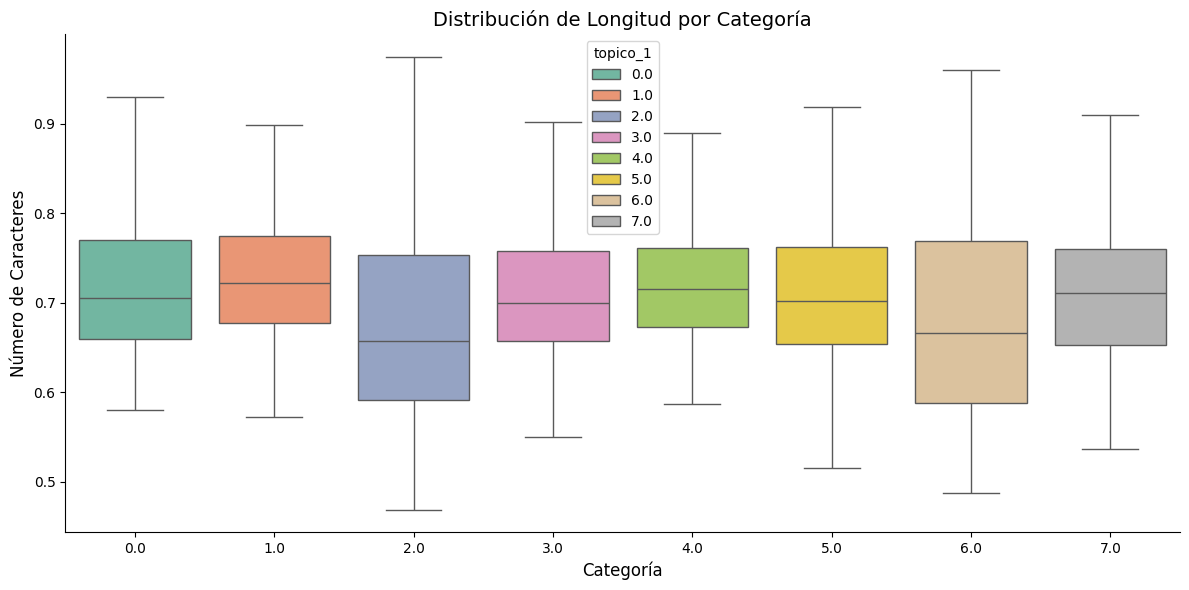

In [13]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_topicos_automaticos, x='topico_1', y='distancia_al_centroide', hue='topico_1',
            palette='Set2', showfliers=False)

plt.title('Distribución de Longitud por Categoría', fontsize=14)
plt.xlabel('Categoría', fontsize=12)
plt.ylabel('Número de Caracteres', fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()

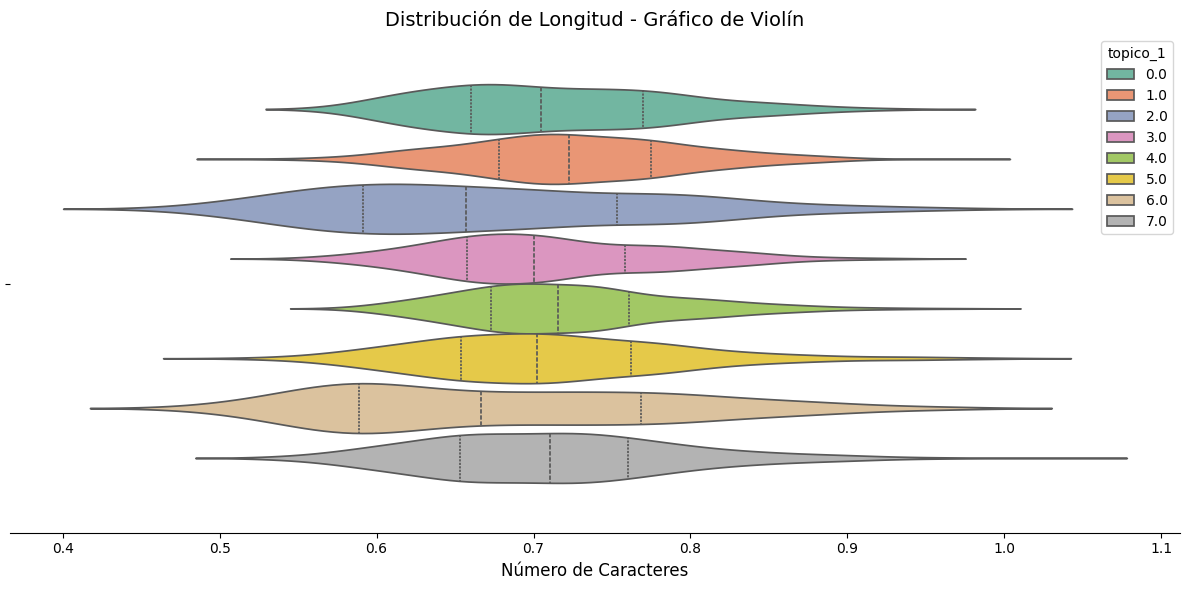

In [14]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_topicos_automaticos, x='distancia_al_centroide', hue='topico_1',
               palette='Set2', 
               inner='quartile', color='skyblue')

plt.title('Distribución de Longitud - Gráfico de Violín', fontsize=14)
plt.xlabel('Número de Caracteres', fontsize=12)

sns.despine(left=True)
plt.tight_layout()
plt.show()

In [15]:
centroides = df_topicos_automaticos.groupby("topico_1")["embeddings"].apply(
    lambda x: np.mean(np.vstack(x.values), axis=0)
).to_dict()

In [16]:
df_topicos_automaticos['label'].value_counts()

label
2    2231
0     156
Name: count, dtype: int64

In [17]:
# df_topicos_automaticos = df_topicos_automaticos[df_topicos_automaticos['distancia_al_centroide']<0.6]
# df_topicos_automaticos2 = df_topicos_automaticos[df_topicos_automaticos['distancia_al_centroide']<0.62]
# df_topicos_automaticos2.shape

In [18]:
# Retirar los embeddigs alejados
df_topicos_automaticos = filter_centroide(df_topicos_automaticos)
df_topicos_automaticos.head()

,id,embeddings,texto,label,importancia_tfidf,topico_1,topico_2,topico_3,distancia_al_centroide
0,113854,"[0.01165767665952444, -0.04814380034804344, -0...",pésimo servicio. no tienen disposición ni tact...,0,4.906597,2.0,4.0,6.0,0.675302
1,73584,"[-0.0033760960213840008, -0.055160701274871826...","no lo recomiendo. no recomiendo este hotel, el...",0,3.503693,5.0,6.0,7.0,0.638598
2,16828,"[-0.032337117940187454, -0.0011940974509343505...",este hotel no tienen acceso a discapacitados. ...,0,4.248525,1.0,3.0,4.0,0.645210
3,67013,"[-0.01615498773753643, 0.02060611918568611, -0...",pésima experiencia en el restaurante. pésimo ...,0,3.772403,2.0,4.0,6.0,0.658180
4,17955,"[0.009223244152963161, 0.016772812232375145, -...",mala comida y muy cara. fuimos un grupo de 11 ...,0,3.612414,6.0,1.0,7.0,0.614390


In [19]:
df_topicos_automaticos['label'].value_counts()

label
2    234
0     66
Name: count, dtype: int64

In [20]:
embedding_matrix = np.vstack(df_topicos_automaticos['embeddings'].values)

# # Topicos automaticos
id = df_topicos_automaticos['id'].values.tolist()
id_topic = df_topicos_automaticos['topico_1'].values.tolist()
id_importancia = df_topicos_automaticos['importancia_tfidf'].values.tolist()
id_label = df_topicos_automaticos['label'].values.tolist()
id_texto = df_topicos_automaticos['texto'].values.tolist()

In [21]:
pca = PCA(n_components=2)
fm = pd.DataFrame(pca.fit_transform(embedding_matrix), columns=['x','y'])

fm['id'] = id
fm['id_topic'] = id_topic
fm['importancia'] = id_importancia
fm['label'] = id_label
fm['texto'] = id_texto

fm['id_topic'] = np.where(fm['id_topic'] == 7, 1, fm['id_topic'])
fm['id_topic'] = np.where(fm['id_topic'] == 6, 2, fm['id_topic'])
fm['id_topic'] = np.where(fm['id_topic'] == 4, 0, fm['id_topic'])
fm['id_topic'] = fm['id_topic'].astype(int).astype(str)

# Aplicar la función a la columna de texto
fm['texto'] = fm['texto'].str.capitalize().apply(lambda x: agregar_saltos_linea(x, ancho=60))

# Modificar la importancia para los negativos
fm["importancia"] = np.exp(fm["importancia"])
fm['importancia'] = np.where(fm['label'] == 0, fm['importancia']*2, fm['importancia'])

fm['label'] = np.where(fm['label'] == 0, 'Negative', 'Positive')

fm.head()

,x,y,id,id_topic,importancia,label,texto
0,0.199473,-0.405403,113854,2,270.357255,Negative,Pésimo servicio. no tienen disposición ni tact...
1,-0.228141,0.020155,73584,5,66.475950,Negative,"No lo recomiendo. no recomiendo este hotel, el..."
2,-0.045530,-0.048362,16828,1,140.004175,Negative,Este hotel no tienen acceso a discapacitados. ...
3,0.220312,-0.284410,67013,2,86.968835,Negative,Pésima experiencia en el restaurante. pésimo s...
4,0.130816,0.029050,17955,2,74.110781,Negative,Mala comida y muy cara. fuimos un grupo de 11 ...


In [22]:
plot_embeddings(fm, title='Embeddings Visualization and Topic Clustering', save=True)

In [23]:
df_topicos_manual = pd.read_parquet(processed/'df_topicos_manual.parquet.gzip')
df_topicos_manual = df_topicos_manual.loc[:,['id', 'eval_pos', 'eval_neg']]
df_topicos_manual['conteo'] = df_topicos_manual[['eval_pos', 'eval_neg']].sum(axis=1)
df_topicos_manual = df_topicos_manual[df_topicos_manual['conteo'] == 1]
df_topicos_manual.drop(['conteo'], axis=1, inplace=True)
df_topicos_manual.head()

,id,eval_pos,eval_neg
0,1,1,0
1,2,1,0
4,5,1,0
5,6,1,0
7,8,1,0


In [24]:
fm = pd.merge(fm, df_topicos_manual, how='left', on=['id']) 
fm = fm.dropna(subset=['eval_pos'])
df_topicos_manual.shape, fm.shape

((118778, 3), (215, 9))

In [25]:
plot_embeddings(fm, title='Embeddings Visualization and Semi-automatic Topic Clustering', save=True)

In [26]:
print('ok_')

ok_
